# Data Segmentation
---

## Purpose

This notebook creates customer segments using a decision tree approach for targeted marketing strategies.

- Build a shallow decision tree (depth 4) to identify segments
- Extract 6 leaf nodes as distinct customer segments
- Profile each segment with summary statistics and key characteristics
- Analyze segment composition and income distribution
- Create bubble chart visualization to compare segment positioning and size

In [1]:
!pip install -r ../requirements.txt -q

In [2]:
# import packages
import numpy as np
import pandas as pd
import warnings
import os

# ignore warnings
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

from scipy import stats

# Scikit Learn
import sklearn
from sklearn.impute import SimpleImputer

# Pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    precision_score,
    brier_score_loss,
    recall_score,
    roc_curve,
    roc_auc_score,
)

# HP Tunings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Bayesian Search
from skopt.space import Integer, Categorical, Real
from skopt import BayesSearchCV

# Resampling
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

import pickle
from utils import *
from sklearn.tree import plot_tree

In [3]:
# load file
df = pd.read_parquet("../data/processed_data.parquet")

In [4]:
os.makedirs("../artifacts/model_plots/", exist_ok=True)

## Using Shallow Decision Tree 
(Each Segment will have different population % of people having income >$50K)

In [5]:
continuous = []
categorical_less_than_10_cat = []
categorical_more_than_9_cat = []

for column in df.columns:
    if df[column].dtype == "int64" or df[column].dtype == "float64":
        if column not in [
            "label",
            "weight",
            "detailed_industry_recode",
            "detailed_occupation_recode",
            "year",
        ]:
            continuous.append(column)

    elif df[column].dtype == "object":
        if column not in ["detailed_household_and_family_stat"]:
            if df[column].nunique() < 10:
                categorical_less_than_10_cat.append(column)

            if df[column].nunique() > 10:
                categorical_more_than_9_cat.append(column)

print("\nContinuous Columns:", continuous)
print("\nCategorical Columns (Less than 10 categories):", categorical_less_than_10_cat)
print("\nCategorical Columns (More than 9 categories):", categorical_more_than_9_cat)


Continuous Columns: ['age', 'wage_per_hour', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'education_numeric', 'country_of_birth_father_is_usa', 'country_of_birth_mother_is_usa', 'country_of_birth_self_is_usa', 'sex_is_male', 'has_capital_gains', 'has_capital_losses', 'has_dividends_from_stocks', 'capital_gains_log', 'capital_losses_log', 'dividends_from_stocks_log']

Categorical Columns (Less than 10 categories): ['class_of_worker', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'race', 'hispanic_origin', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'citizenship',

In [6]:
# columns for target encoding, one hot encoding and numeric
cols_for_target_encoding = categorical_more_than_9_cat
cols_for_numeric = continuous
cols_for_dummies = categorical_less_than_10_cat
weight_col = "weight"

In [7]:
cols_to_filter = cols_for_target_encoding + cols_for_numeric + cols_for_dummies
df = shuffle(df).reset_index(drop=True)

target_model = df["label"]
df_final_model = df[cols_to_filter]
sample_weights = df[weight_col]

In [8]:
# Undersampling

sample_weights = df[weight_col]

n_minority = (target_model == 1).sum()
n_majority = (target_model == 0).sum()

target_event_rate = 0.10
sampling_strategy = target_event_rate / (1 - target_event_rate)

print(f"\nTarget event rate: {target_event_rate:.2%}")
print(f"Required sampling_strategy: {sampling_strategy:.6f}")

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_under_sampled, y_under_sampled = rus.fit_resample(df_final_model, target_model)

undersampled_indices = rus.sample_indices_
weights_under_sampled = sample_weights.iloc[undersampled_indices].values

print(f"\nObservations prior to Under Sampling: {df_final_model.shape[0]}")
print(f"Observations after Under Sampling: {X_under_sampled.shape[0]}")
print(f"\nOriginal dataset >$50K Income rate: {target_model.mean():2%}")
print(
    f"Original dataset weighted >$50K Income rate: {np.average(target_model, weights=sample_weights):.2%}"
)
print(f"\nUnderSampled dataset >$50K Income rate: {y_under_sampled.mean():.2%}")
print(
    f"UnderSampled dataset weighted >$50K Income rate: {np.average(y_under_sampled, weights=weights_under_sampled):.2%}"
)


Target event rate: 10.00%
Required sampling_strategy: 0.111111

Observations prior to Under Sampling: 199523
Observations after Under Sampling: 123819

Original dataset >$50K Income rate: 6.205801%
Original dataset weighted >$50K Income rate: 6.41%

UnderSampled dataset >$50K Income rate: 10.00%
UnderSampled dataset weighted >$50K Income rate: 10.30%


In [9]:
# Stratified Train-Test Split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_under_sampled,
    y_under_sampled,
    weights_under_sampled,
    test_size=0.2,
    random_state=42,
    stratify=y_under_sampled,
)

print(f"Training datset: {X_train.shape[0]}")
print(f"Test dataset: {X_test.shape[0]}")
print(f"\nTraining unweighted event rate: {y_train.mean():.2%}")
print(f"Training weighted event rate: {np.average(y_train, weights=weights_train):.2%}")
print(f"\nTest unweighted event rate: {y_test.mean():.2%}")
print(f"Test weighted event rate: {np.average(y_test, weights=weights_test):.2%}")

Training datset: 99055
Test dataset: 24764

Training unweighted event rate: 10.00%
Training weighted event rate: 10.29%

Test unweighted event rate: 10.00%
Test weighted event rate: 10.36%


In [10]:
# Pipeline for Model

numeric_pipeline = make_pipeline(SimpleImputer(strategy="mean"))

ohe_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="not in universe"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

target_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="not in universe"),
    TargetEncoder(
        handle_unknown="ignore",
        handle_missing="value",
    ),
)

processing = make_column_transformer(
    (numeric_pipeline, cols_for_numeric),
    (ohe_pipeline, cols_for_dummies),
    (target_pipeline, cols_for_target_encoding),
    remainder="drop",
)

In [11]:
# Shallow Decision Tree
search_spaces = {
    "ccp_alpha": Real(1e-6, 20, prior="uniform"),
}

shallow_decision_tree_model = make_pipeline(
    processing,
    BayesSearchCV(
        DecisionTreeClassifier(
            random_state=42,
            max_depth=4,
            max_leaf_nodes=6,
            criterion="gini",
        ),
        search_spaces=search_spaces,
        n_jobs=-1,
        cv=2,
    ),
)
shallow_decision_tree_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa',
                                                   'country_of_birth_mother_is_us...
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder(handle_unknown='ignore'))]),
                                                  ['major_industry_code',
                                                   'major_occupation_code'])])),
                ('bayessearchcv',
                 BayesSearchCV(cv=2,
                               estimator=DecisionTreeClassifier(max_depth=4,
                                                                max_leaf_nodes=6,
                                                                random_state=42),
                               n_jobs=-1,
                               search_spaces={'ccp_alpha': Real(low=1e-06, high=20, prior='uniform', transform='identity')}))])

In [12]:
shallow_decision_tree_model_object = shallow_decision_tree_model.fit(
    X_train, y_train, bayessearchcv__sample_weight=weights_train
)

os.makedirs("../artifacts/model_objects/", exist_ok=True)
with open("../artifacts/model_objects/shallow_decision_tree_model.pkl", "wb") as file:
    pickle.dump(shallow_decision_tree_model_object, file)

#### Plotting tree

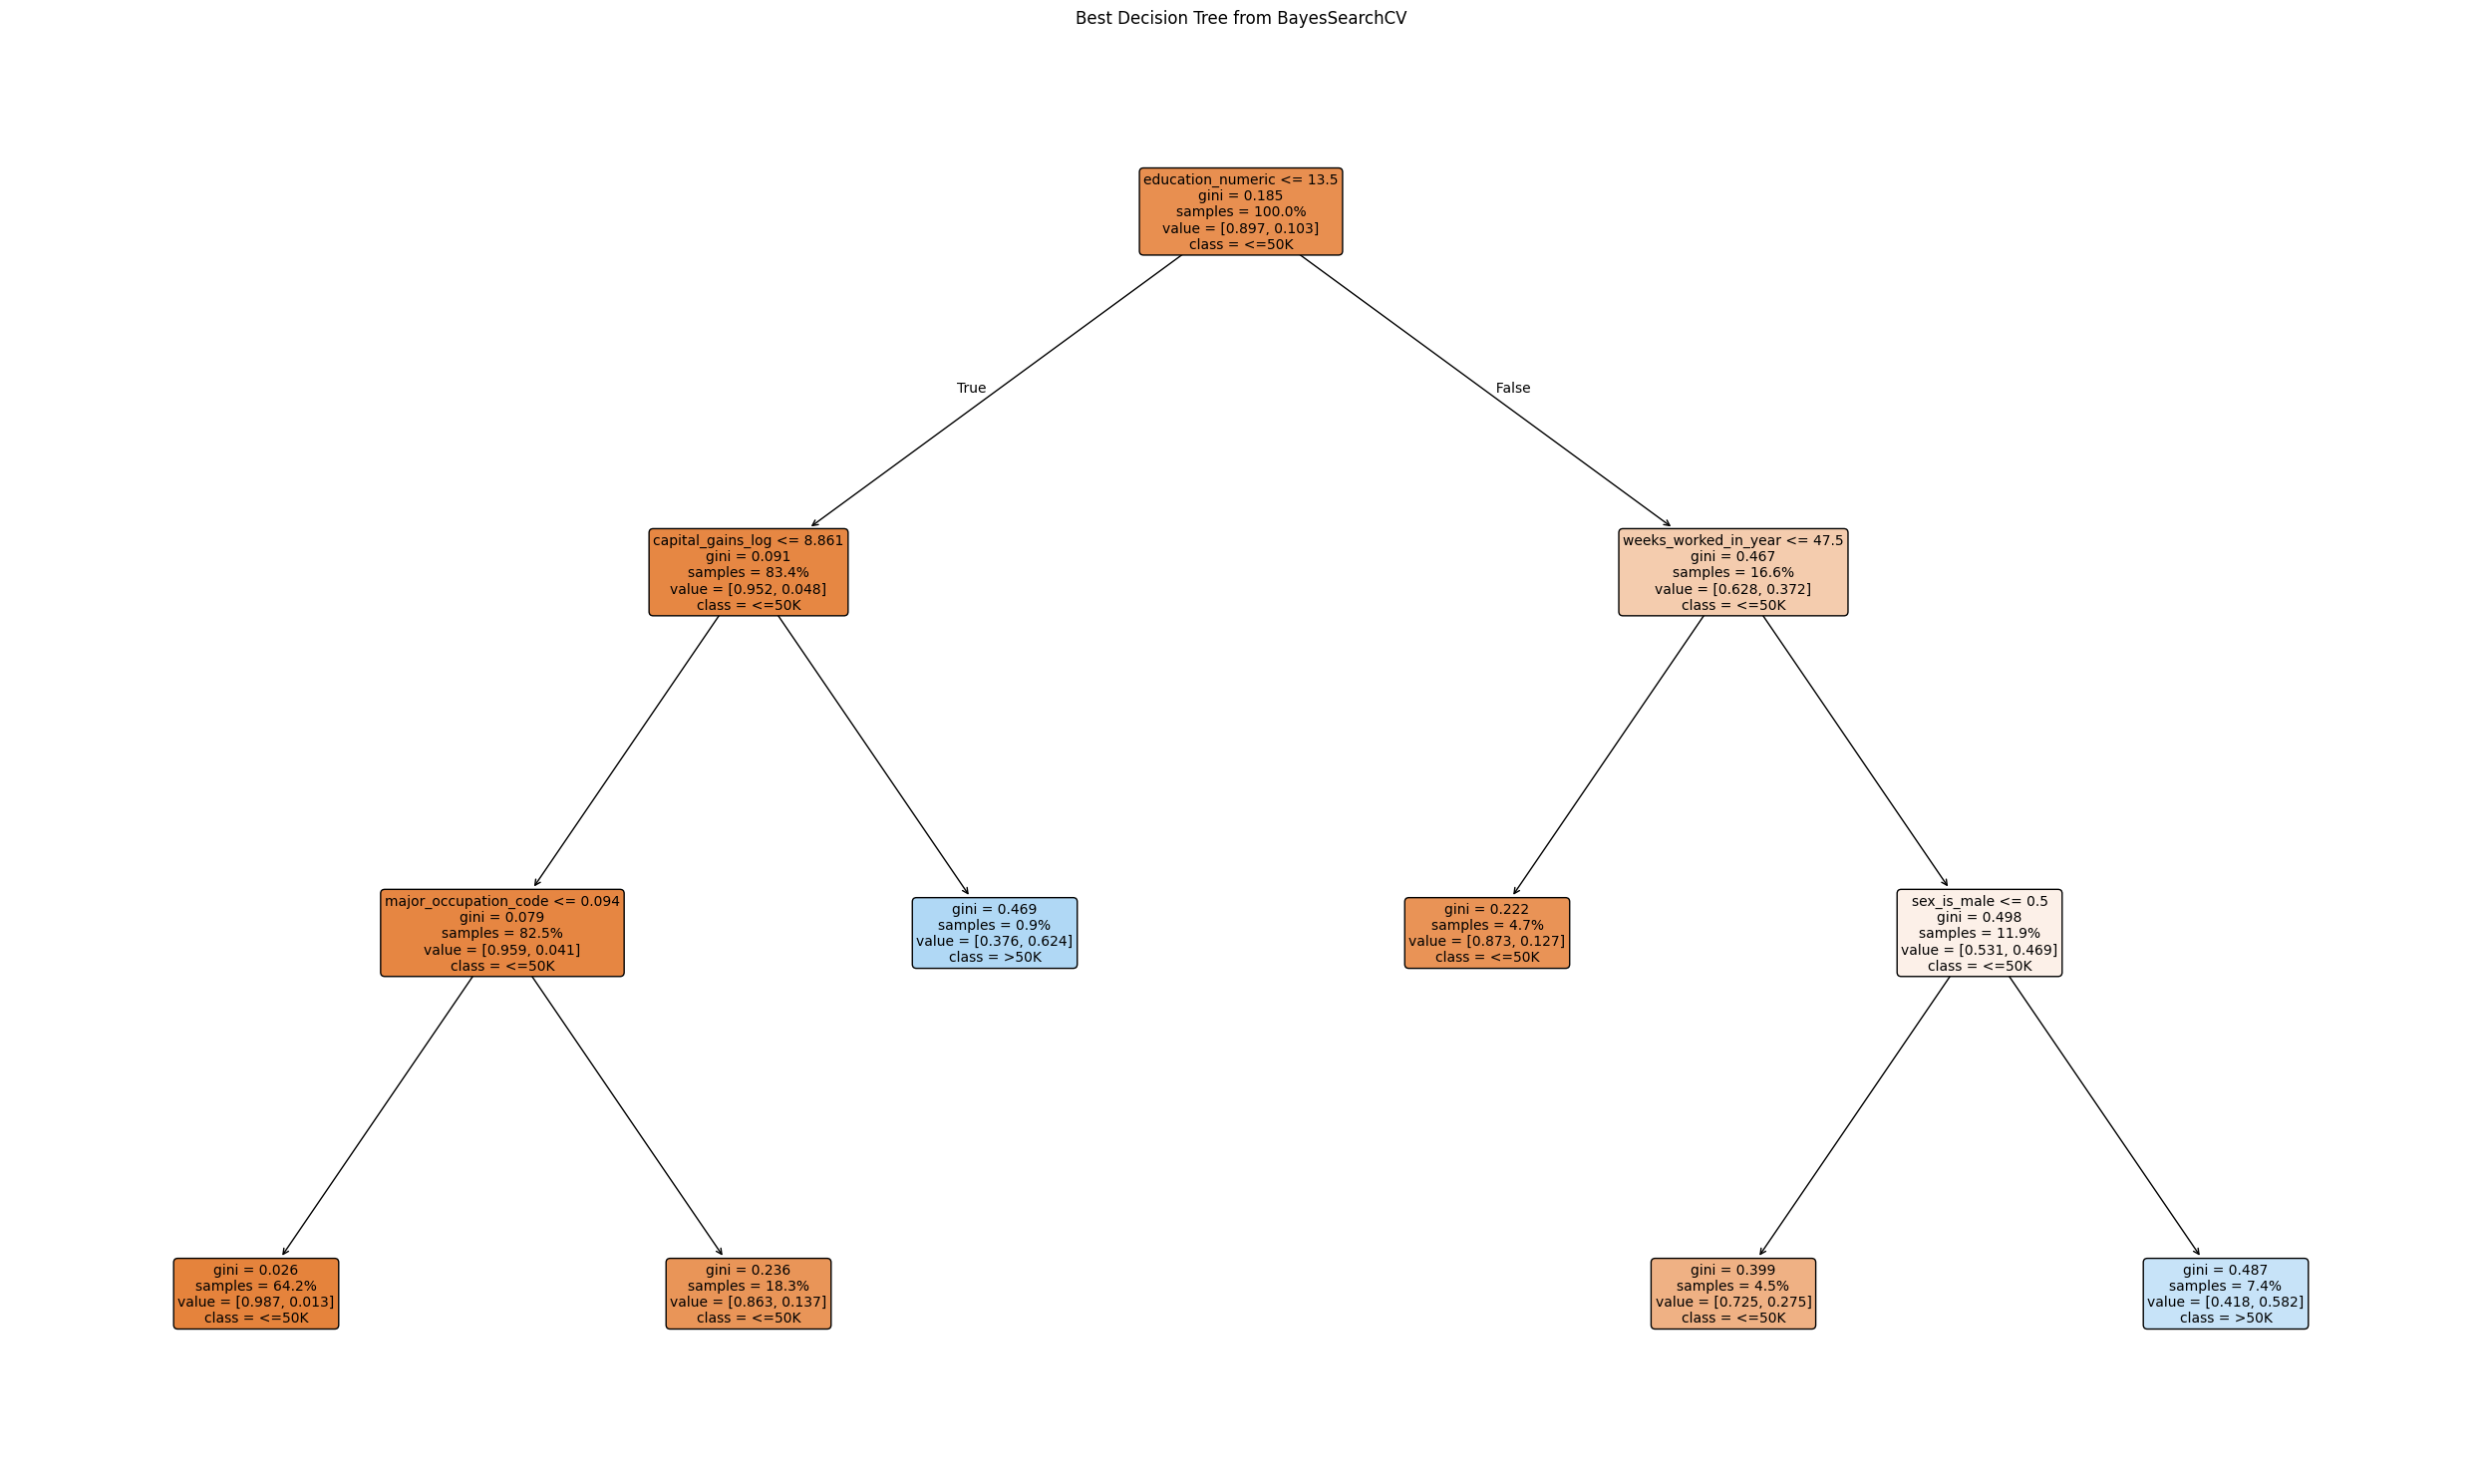

In [13]:
best_tree = shallow_decision_tree_model_object.named_steps[
    "bayessearchcv"
].best_estimator_

model_object_from_pipe = shallow_decision_tree_model_object[1]

if hasattr(model_object_from_pipe, "best_estimator_"):
    shallow_decision_tree = model_object_from_pipe.best_estimator_
else:
    shallow_decision_tree = model_object_from_pipe

combined_features = list(processing.get_feature_names_out())
ohe_features = [
    col.split("__", 1)[1] for col in combined_features if col.startswith("pipeline-2__")
]
feature_names = cols_for_numeric + ohe_features + cols_for_target_encoding

plt.figure(figsize=(25, 15))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    filled=True,
    rounded=True,
    max_depth=None,
    fontsize=10,
    proportion=True,
)
plt.title("Best Decision Tree from BayesSearchCV")
plt.tight_layout()
plt.savefig(
    "../artifacts/model_plots/decision_tree_for_segmentation.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Profile Segments

In [14]:
X_train_transfomed = processing.transform(X_train)
combined_features = list(processing.get_feature_names_out())
ohe_features = [
    col.split("__", 1)[1] for col in combined_features if col.startswith("pipeline-2__")
]
feature_names = cols_for_numeric + ohe_features + cols_for_target_encoding

# Final transaformed data
X_train_transfomed = pd.DataFrame(data=X_train_transfomed, columns=feature_names)

In [15]:
# Manually extracted conditions from decision tree; 6 leaf nodes
conditions = [
    (X_train_transfomed["education_numeric"] <= 13.5)
    & (X_train_transfomed["capital_gains_log"] <= 8.8613)
    & (X_train_transfomed["major_occupation_code"] <= 0.0941),
    (X_train_transfomed["education_numeric"] <= 13.5)
    & (X_train_transfomed["capital_gains_log"] <= 8.8613)
    & (X_train_transfomed["major_occupation_code"] > 0.0941),
    (X_train_transfomed["education_numeric"] <= 13.5)
    & (X_train_transfomed["capital_gains_log"] > 8.8613),
    (X_train_transfomed["education_numeric"] > 13.5)
    & (X_train_transfomed["weeks_worked_in_year"] <= 47.5),
    (X_train_transfomed["education_numeric"] > 13.5)
    & (X_train_transfomed["weeks_worked_in_year"] > 47.5)
    & (X_train_transfomed["sex_is_male"] <= 0.5),
    (X_train_transfomed["education_numeric"] > 13.5)
    & (X_train_transfomed["weeks_worked_in_year"] > 47.5)
    & (X_train_transfomed["sex_is_male"] > 0.5),
]

values = [1, 2, 3, 4, 5, 6]
X_train_transfomed["segment_number"] = np.select(conditions, values, default=np.nan)
print(X_train_transfomed["segment_number"].value_counts(dropna=False))

segment_number
1.0    63621
2.0    18084
6.0     7333
4.0     4696
5.0     4419
3.0      902
Name: count, dtype: int64


In [16]:
y_series = y_train.reset_index(drop=True)
weights_array = weights_train

X_profile = X_train_transfomed.copy()
X_profile["target"] = y_series
X_profile["weight"] = weights_array

continuous_vars = [
    "has_capital_gains",
    "has_capital_losses",
    "has_dividends_from_stocks",
    "age",
    "wage_per_hour",
    "education_numeric",
    "sex_is_male",
    "country_of_birth_self_is_usa",
]

categorical_vars = ["enroll_in_edu_inst_last_wk", "class_of_worker"]
ohe_cols = [
    col
    for cat in categorical_vars
    for col in X_profile.columns
    if col.startswith(f"{cat}_")
]

In [17]:
# groupby summary for each segment

agg_dict = {
    "count": ("segment_number", "size"),
    "weighted_count": ("weight", "sum"),
    "event_rate_unweighted": ("target", "mean"),
    **{f"mean_{var}": (var, "mean") for var in continuous_vars},
    **{f"cat_{col}": (col, "mean") for col in ohe_cols},
}

segment_groups = X_profile.groupby("segment_number")
final_profile = segment_groups.agg(**agg_dict)
final_profile["event_rate_weighted"] = segment_groups.apply(weighted_mean)
final_profile["population_%"] = (
    final_profile["count"] / final_profile["count"].sum()
) * 100

profile = final_profile.copy()

# Format all columns at once
format_map = {
    "event_rate_unweighted": lambda x: f"{x * 100:.2f}%",
    "event_rate_weighted": lambda x: f"{x * 100:.2f}%",
    "population_%": lambda x: f"{x:.2f}%",
    "count": lambda x: f"{x:,}",
    "weighted_count": lambda x: f"{x:,.0f}",
}

for col, fmt in format_map.items():
    profile[col] = profile[col].apply(fmt)

profile.to_csv("../artifacts/model_plots/segments_summary.csv", index=False)
profile.head(6)

,count,weighted_count,event_rate_unweighted,mean_has_capital_gains,mean_has_capital_losses,mean_has_dividends_from_stocks,mean_age,mean_wage_per_hour,mean_education_numeric,mean_sex_is_male,...,cat_class_of_worker_local government,cat_class_of_worker_never worked,cat_class_of_worker_not in universe,cat_class_of_worker_private,cat_class_of_worker_self-employed-incorporated,cat_class_of_worker_self-employed-not incorporated,cat_class_of_worker_state government,cat_class_of_worker_without pay,event_rate_weighted,population_%
segment_number,,,,,,,,,,,,,,,,,,,,,
1.0,"63,621","109,382,470",1.30%,0.014822,0.009997,0.056444,31.250483,34.551563,6.091275,0.427265,...,0.016315,0.003427,0.709247,0.227724,0.003882,0.020544,0.009682,0.000739,1.31%,64.23%
2.0,"18,084","32,469,272",13.57%,0.035390,0.037326,0.128290,39.109710,124.384373,10.175570,0.643276,...,0.061104,0.000000,0.000000,0.746903,0.043796,0.093066,0.030192,0.000995,13.66%,18.26%
3.0,902,"1,540,770",63.97%,1.000000,0.000000,0.311530,47.395787,89.576497,10.544346,0.778271,...,0.038803,0.000000,0.121951,0.587583,0.082040,0.107539,0.014412,0.000000,62.43%,0.91%
4.0,"4,696","8,320,178",12.82%,0.069421,0.029174,0.311116,49.535136,36.883092,14.430366,0.415886,...,0.094336,0.001704,0.542802,0.257666,0.012138,0.046210,0.033859,0.000852,12.72%,4.74%
5.0,"4,419","7,773,977",27.00%,0.061100,0.039602,0.297805,40.047069,92.250283,14.445576,0.000000,...,0.183526,0.000000,0.009278,0.592894,0.025798,0.068341,0.079430,0.001810,27.54%,4.46%
6.0,"7,333","13,316,923",57.96%,0.169235,0.082776,0.383336,42.773626,64.422610,14.624983,1.000000,...,0.078549,0.000000,0.019365,0.601255,0.087959,0.101732,0.063548,0.000409,58.19%,7.40%


### Bubble Chart

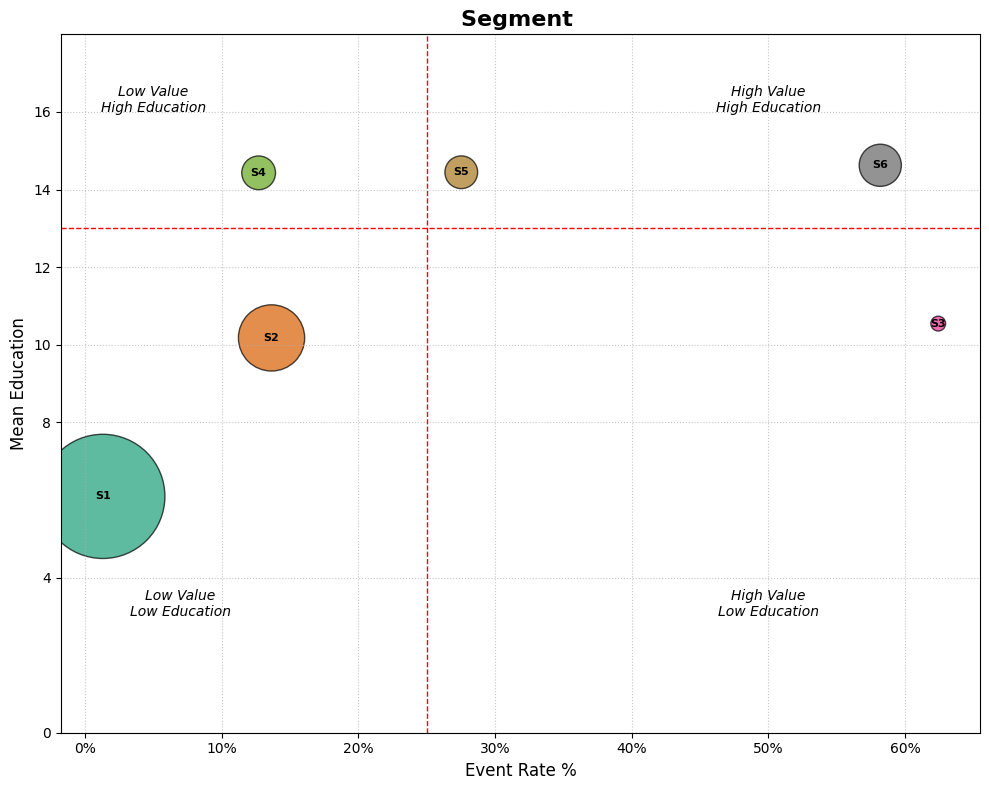

In [18]:
df = final_profile.copy()
df["bubble_size"] = (df["population_%"] / df["population_%"].max()) * 8000

colors = plt.cm.Dark2(np.linspace(0, 1, len(df)))

fig, ax = plt.subplots(figsize=(10, 8), facecolor="white")
scatter = ax.scatter(
    df["event_rate_weighted"],
    df["mean_education_numeric"],
    s=df["bubble_size"],
    c=colors,
    alpha=0.7,
    edgecolors="black",
    linewidth=1,
)

for idx, row in df.iterrows():
    ax.annotate(
        f"S{int(idx)}",
        (row["event_rate_weighted"], row["mean_education_numeric"]),
        ha="center",
        va="center",
        fontsize=8,
        color="black",
        weight="bold",
    )

ax.text(0.05, 16, "Low Value\nHigh Education", ha="center", fontsize=10, style="italic")
ax.text(
    0.50, 16, "High Value\nHigh Education", ha="center", fontsize=10, style="italic"
)
ax.text(0.07, 3, "Low Value\nLow Education", ha="center", fontsize=10, style="italic")
ax.text(0.50, 3, "High Value\nLow Education", ha="center", fontsize=10, style="italic")

ax.axvline(0.25, color="red", linestyle="--", linewidth=1)
ax.axhline(13, color="red", linestyle="--", linewidth=1)

ax.set_title("Segment ", fontsize=16, weight="bold")
ax.set_xlabel("Event Rate %", fontsize=12)
ax.set_ylabel("Mean Education", fontsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylim(0, 18)
ax.set_yticks([0, 4, 8, 10, 12, 14, 16])
plt.grid(True, linestyle=":", alpha=0.7)

plt.tight_layout()
plt.savefig(
    "../artifacts/model_plots/segment_profile.png", dpi=300, bbox_inches="tight"
)
plt.show()